## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
pd.set_option('use_inf_as_na', True)
from collections import Counter

## Loading the Data Set (you need to put in the file where you have stored the data)

In [2]:
raw_data = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\dataset.pkl')

In [3]:
raw_data.columns

Index(['actq', 'apq', 'atq', 'ceqq', 'cheq', 'cogsq', 'csh12q', 'cshfdq',
       'cshiq', 'cshopq',
       ...
       'sector_code_815.0', 'sector_code_817.0', 'sector_code_822.0',
       'sector_code_823.0', 'sector_code_825.0', 'sector_code_830.0',
       'sector_code_835.0', 'sector_code_840.0', 'sector_code_845.0',
       'sector_code_850.0'],
      dtype='object', length=731)

In [4]:
raw_data = raw_data.drop([x  for x in raw_data.columns if 'fqtr' in x],axis=1)

## Restricting to Companies with Market Cap > 1 Billion

In [5]:
data = raw_data[raw_data['market_cap'] > 1000.0]

## The Total Number of Companies w/ Market Cap > 1 Billion that appear during our time horizon

In [9]:
len(data.index.get_level_values(1).unique())

4076

In [10]:
data.head()

actq       apq        atq       ceqq      cheq  \
date       ticker                                                       
2000-02-09 CSCO    7722.000   482.000  21391.000  16523.000  3968.000   
           ROP      172.725    19.662    474.649    239.432     3.198   
2000-02-10 CMOS     240.767    27.044    376.536    209.411    68.625   
2000-02-11 DELL    7681.000  3538.000  11471.000   5308.000  4132.000   
2000-02-15 VAL      507.082   139.497   1094.080    402.382    27.605   

                      cogsq     csh12q    cshfdq     cshiq  cshopq  ...  \
date       ticker                                                   ...   
2000-02-09 CSCO    1422.000  3374.1250  3648.000  3445.000     0.0  ...   
           ROP       47.634    30.2688    31.217       NaN     0.0  ...   
2000-02-10 CMOS      43.023    21.4360    23.753       NaN     0.0  ...   
2000-02-11 DELL    5452.000  2536.0000  2731.000  2575.000     0.0  ...   
2000-02-15 VAL      221.366    43.1858    43.687    53.321     0.0  ...   

                   sector_code_815.0  sector_code_817.0  sector_code_822.0  \
date       ticker                                                            
2000-02-09 CSCO                    0                  0                  0   
           ROP                     0                  0                  0   
2000-02-10 CMOS                    0                  0                  0   
2000-02-11 DELL                    0                  0                  0   
2000-02-15 VAL                     0                  0                  0   

                   sector_code_823.0  sector_code_825.0  sector_code_830.0  \
date       ticker                                                            
2000-02-09 CSCO                    0                  0                  0   
           ROP                     0                  0                  0   
2000-02-10 CMOS                    0                  0                  0   
2000-02-11 DELL                    0                  0                  0   
2000-02-15 VAL                     0                  0                  0   

                   sector_code_835.0  sector_code_840.0  sector_code_845.0  \
date       ticker                                                            
2000-02-09 CSCO                    0                  0                  0   
           ROP                     0                  0                  0   
2000-02-10 CMOS                    0                  0                  0   
2000-02-11 DELL                    0                  0                  0   
2000-02-15 VAL                     0                  0                  0   

                   sector_code_850.0  
date       ticker                     
2000-02-09 CSCO                    0  
           ROP                     0  
2000-02-10 CMOS                    0  
2000-02-11 DELL                    0  
2000-02-15 VAL                     0  

[5 rows x 727 columns]

## Filling in Missing Values

In [11]:
data = data.copy()
data.replace([np.inf,-np.inf],np.nan,inplace=True)
data = data.fillna(method='ffill')

In [12]:
data = data.fillna(0)

#### We label a Data Point +1 if the difference between the return on the SPY and the return on the stock exceeds 1.0% during the earnings period, -1 if it is < -2.5% and 0 if it is between -1% and +1%. The function below turns the return differences into labels

In [13]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -1
    else:
        return 0

#### Applying the function to the column of relative returns and making a column of labels

In [14]:
data = data.copy()
data['rel_performance'] = data['pred_rel_return'].apply(f)

In [15]:
data['next_period_return'].to_frame()

next_period_return
date       ticker                    
2000-02-09 CSCO             -0.037098
           ROP               0.077255
2000-02-10 CMOS              0.287974
2000-02-11 DELL              0.346867
2000-02-15 VAL               0.093507
...                               ...
2018-12-21 NKE              -0.207949
           SAFM             -0.207949
           SCHL             -0.207949
           WBA              -0.207949
2018-12-24 KMX              -0.207949

[111468 rows x 1 columns]

#### This is the column of labels

In [16]:
data['rel_performance']

date        ticker
2000-02-09  CSCO     -1
            ROP       1
2000-02-10  CMOS      1
2000-02-11  DELL      1
2000-02-15  VAL       1
                     ..
2018-12-21  NKE      -1
            SAFM     -1
            SCHL     -1
            WBA      -1
2018-12-24  KMX      -1
Name: rel_performance, Length: 111468, dtype: int64

### Make date the index, remember that the date is the first business day after Earnings Release

In [17]:
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

### This what the data set looks like now

In [18]:
data

,ticker,actq,apq,atq,ceqq,cheq,cogsq,csh12q,cshfdq,cshiq,...,sector_code_817.0,sector_code_822.0,sector_code_823.0,sector_code_825.0,sector_code_830.0,sector_code_835.0,sector_code_840.0,sector_code_845.0,sector_code_850.0,rel_performance
date,,,,,,,,,,,,,,,,,,,,,
2000-02-09,CSCO,7722.000,482.000,21391.000,16523.000,3968.000,1422.000,3374.1250,3648.000,3445.000,...,0,0,0,0,0,0,0,0,0,-1
2000-02-09,ROP,172.725,19.662,474.649,239.432,3.198,47.634,30.2688,31.217,3445.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-10,CMOS,240.767,27.044,376.536,209.411,68.625,43.023,21.4360,23.753,3445.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-11,DELL,7681.000,3538.000,11471.000,5308.000,4132.000,5452.000,2536.0000,2731.000,2575.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-15,VAL,507.082,139.497,1094.080,402.382,27.605,221.366,43.1858,43.687,53.321,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,NKE,15566.000,2574.000,22677.000,8729.000,4041.000,5098.000,1601.1500,1620.700,1577.000,...,0,0,0,0,0,0,0,0,0,-1
2018-12-21,SAFM,566.489,128.936,1659.440,1387.893,121.193,758.313,22.4290,22.191,22.100,...,0,0,0,0,0,0,0,0,0,-1
2018-12-21,SCHL,1172.300,250.300,2081.900,1284.600,358.100,262.400,35.0420,35.863,22.100,...,0,0,0,0,0,0,0,0,0,-1


### We use a training period of 3 years = 12 quarters, 

In [271]:
df_train = data.loc['2001-01-01':'2004-01-01']

#### The validation set and test set are the quarters starting 1 quarter after the end of the training periods

In [272]:
df_valid = data.loc['2004-04-01':'2004-07-01']
df_test = data.loc['2004-07-01':'2004-10-01']

#### Next we delete the columns that are not needed for training

In [273]:
train = df_train.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret',
                                    ],axis=1)
test = df_test.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret',
                            ],axis=1)

#### We take out the actual  earnings period stock returns in the training and test sets

In [274]:
train_stock_returns = df_train['next_period_return']
valid_stock_returns = df_valid['next_period_return']
test_stock_returns = df_test['next_period_return']

In [275]:
train_stock_returns

date
2001-01-04    0.201443
2001-01-04    0.048484
2001-01-04    0.447645
2001-01-04   -0.048728
2001-01-05    0.135641
                ...   
2003-12-23    0.018955
2003-12-23    0.099985
2003-12-24    0.126163
2003-12-24    0.162094
2003-12-30   -0.101622
Name: next_period_return, Length: 10831, dtype: float64

In [276]:
df_test['next_period_return']

date
2004-07-01   -0.145167
2004-07-01   -0.047005
2004-07-01    0.042538
2004-07-01   -0.021609
2004-07-01    0.615598
                ...   
2004-09-30   -0.133421
2004-10-01    0.221661
2004-10-01   -0.041192
2004-10-01    0.081742
2004-10-01    0.448129
Name: next_period_return, Length: 1173, dtype: float64

In [277]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [278]:
scaler = StandardScaler()

In [279]:
float_vars = [x for x in train.columns if data[x].dtype == 'float64']

In [280]:
len(float_vars)

179

In [281]:
train = train.copy()
valid = valid.copy()
test = test.copy()

In [282]:
train[float_vars] = scaler.fit_transform(train[float_vars])
valid[float_vars] = scaler.transform(valid[float_vars])
test[float_vars] = scaler.transform(test[float_vars])

In [283]:
test

,actq,apq,atq,ceqq,cheq,cogsq,csh12q,cshfdq,cshiq,cshopq,...,sector_code_815.0,sector_code_817.0,sector_code_822.0,sector_code_823.0,sector_code_825.0,sector_code_830.0,sector_code_835.0,sector_code_840.0,sector_code_845.0,sector_code_850.0
0,-0.438767,-0.161873,-0.235134,-0.341905,-0.147277,-0.325873,-0.349703,-0.350949,-0.366882,-0.009609,...,0,0,0,0,0,0,0,0,0,0
1,0.094177,-0.125843,-0.015003,0.208784,-0.090472,0.052252,0.051467,0.062889,0.183724,-0.009609,...,0,0,0,0,0,0,0,0,0,0
2,0.408269,-0.152161,-0.139735,0.230254,-0.123531,-0.156303,-0.088338,-0.081644,-0.101699,84.359788,...,0,0,0,0,0,0,0,0,0,0
3,2.566442,-0.080888,0.466614,1.698205,0.482840,0.700423,0.956550,0.953576,0.917649,-0.009609,...,0,0,0,0,0,0,0,0,0,0
4,2.566442,2.107178,1.292687,-0.080646,0.272097,-0.092871,-0.253923,-0.256145,-0.254256,-0.009609,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,-0.165027,-0.115511,-0.180275,0.069534,-0.116088,-0.008809,-0.233836,-0.235539,-0.253813,-0.009609,...,0,0,0,0,0,0,0,0,0,0
1169,-0.263658,-0.161292,-0.237062,-0.198178,-0.075701,-0.301716,-0.199487,-0.173131,-0.204266,-0.009609,...,0,0,0,0,0,0,0,0,0,0
1170,1.098392,-0.096349,0.239014,0.115424,0.008394,-0.007514,0.329885,0.333040,0.353212,-0.009609,...,0,0,0,0,0,0,0,0,0,0
1171,-0.244494,-0.145633,-0.236138,-0.262953,-0.132820,-0.114253,-0.204665,-0.210057,-0.204298,164.468104,...,0,0,0,0,0,0,0,0,0,0


In [284]:
y_train = df_train['rel_performance'].values
y_valid = df_valid['rel_performance'].values
y_test = df_test['rel_performance'].values

In [285]:
Counter(y_valid)

Counter({1: 631, -1: 403, 0: 121})

## Number of Features

In [286]:
len(train.columns)

721

## Importing the Tree Classifier and some metrics from sklearn

In [287]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.metrics import accuracy_score,confusion_matrix

In [357]:
t_clf = DecisionTreeClassifier(min_samples_leaf = 100,max_depth=15)

In [358]:
t_clf.fit(train,y_train)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=100)

In [359]:
accuracy_score(y_train,t_clf.predict(train))

0.6111162404210138

In [360]:
accuracy_score(y_valid,t_clf.predict(valid))

0.5099567099567099

### Visualizing the tree

In [361]:
import graphviz
from sklearn import tree

In [362]:
dot_data = tree.export_graphviz(t_clf,out_file=None)
graph = graphviz.Source(dot_data)
graph.render('tree_10')

'tree_10.pdf'

In [171]:
import optuna
from optuna.trial import Trial
# optuna.logging.set_verbosity(optuna.logging.get_verbosity)
# import warnings
# warnings.filterwarnings("ignore")

In [172]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    t_min_samples_leaf = trial.suggest_int('min_samples_leaf',100,1200,step=100)
    t_max_depth = trial.suggest_int('max_depth',5,25,step=5)

    
    t_clf = DecisionTreeClassifier(min_samples_leaf = t_min_samples_leaf,max_depth=t_max_depth,random_state=123)
    t_clf.fit(train,labels)

    preds = t_clf.predict(val)
    profit = (preds * val_rets).sum()

    return profit


In [370]:
study = optuna.create_study(direction="maximize")

[I 2023-01-09 10:08:58,766] A new study created in memory with name: no-name-a2abfd1c-466b-4e98-b6e5-80ee35725f3d


In [371]:
from functools import partial

In [372]:
%%time
study.optimize(partial(objective,train=train,labels=y_train,val=valid,val_labels=y_valid,val_rets=valid_stock_returns.values), n_trials=100,n_jobs=-1)

[I 2023-01-09 10:09:02,799] Trial 2 finished with value: -26.053565999999996 and parameters: {'min_samples_leaf': 1100, 'max_depth': 10}. Best is trial 2 with value: -26.053565999999996.
[I 2023-01-09 10:09:02,944] Trial 4 finished with value: 0.7952580000000218 and parameters: {'min_samples_leaf': 900, 'max_depth': 15}. Best is trial 4 with value: 0.7952580000000218.
[I 2023-01-09 10:09:02,962] Trial 7 finished with value: 0.7952580000000218 and parameters: {'min_samples_leaf': 900, 'max_depth': 5}. Best is trial 4 with value: 0.7952580000000218.
[I 2023-01-09 10:09:02,991] Trial 0 finished with value: 0.3619260000000235 and parameters: {'min_samples_leaf': 600, 'max_depth': 5}. Best is trial 4 with value: 0.7952580000000218.
[I 2023-01-09 10:09:03,198] Trial 1 finished with value: 0.8414420000000256 and parameters: {'min_samples_leaf': 200, 'max_depth': 5}. Best is trial 1 with value: 0.8414420000000256.
[I 2023-01-09 10:09:03,281] Trial 6 finished with value: 0.3619260000000235 and 

[I 2023-01-09 10:09:12,465] Trial 41 finished with value: 4.020640000000023 and parameters: {'min_samples_leaf': 300, 'max_depth': 15}. Best is trial 16 with value: 4.020640000000023.
[I 2023-01-09 10:09:12,533] Trial 44 finished with value: 4.020640000000023 and parameters: {'min_samples_leaf': 300, 'max_depth': 15}. Best is trial 16 with value: 4.020640000000023.
[I 2023-01-09 10:09:12,611] Trial 47 finished with value: 0.3619260000000235 and parameters: {'min_samples_leaf': 500, 'max_depth': 15}. Best is trial 16 with value: 4.020640000000023.
[I 2023-01-09 10:09:12,664] Trial 45 finished with value: 4.020640000000023 and parameters: {'min_samples_leaf': 300, 'max_depth': 15}. Best is trial 16 with value: 4.020640000000023.
[I 2023-01-09 10:09:12,730] Trial 43 finished with value: -2.4917439999999758 and parameters: {'min_samples_leaf': 200, 'max_depth': 15}. Best is trial 16 with value: 4.020640000000023.
[I 2023-01-09 10:09:12,895] Trial 46 finished with value: -2.4917439999999758

[I 2023-01-09 10:09:24,005] Trial 84 finished with value: 2.2530960000000224 and parameters: {'min_samples_leaf': 400, 'max_depth': 20}. Best is trial 16 with value: 4.020640000000023.
[I 2023-01-09 10:09:24,070] Trial 85 finished with value: 2.2530960000000224 and parameters: {'min_samples_leaf': 400, 'max_depth': 15}. Best is trial 16 with value: 4.020640000000023.
[I 2023-01-09 10:09:24,430] Trial 87 finished with value: 2.2530960000000224 and parameters: {'min_samples_leaf': 400, 'max_depth': 20}. Best is trial 16 with value: 4.020640000000023.
[I 2023-01-09 10:09:24,495] Trial 86 finished with value: 2.2530960000000224 and parameters: {'min_samples_leaf': 400, 'max_depth': 20}. Best is trial 16 with value: 4.020640000000023.
[I 2023-01-09 10:09:24,623] Trial 88 finished with value: 2.2530960000000224 and parameters: {'min_samples_leaf': 400, 'max_depth': 15}. Best is trial 16 with value: 4.020640000000023.
[I 2023-01-09 10:09:24,907] Trial 89 finished with value: 2.253096000000022

CPU times: total: 2min 43s
Wall time: 25.9 s


In [373]:
study.best_params

{'min_samples_leaf': 300, 'max_depth': 5}

## Instantiating the classifier with hyper-parameters

In [378]:
t_clf = DecisionTreeClassifier(**study.best_params,random_state=123)

## Now we can fit the tree with the training data

In [379]:
t_clf.fit(train,y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=300, random_state=123)

### and see how well it fits the training data

In [380]:
t_clf.score(train,y_train)

0.5901578801588034

### and predicts the validation data

In [381]:
t_clf.score(valid,y_valid)

0.5844155844155844

### The predicted labels on the validation set and their counts

In [382]:
pred_valid = t_clf.predict(valid)

In [383]:
Counter(pred_valid)

Counter({1: 1055, -1: 100})

In [384]:
confusion_matrix(pred_valid,y_valid)

array([[ 68,   8,  24],
       [  0,   0,   0],
       [335, 113, 607]], dtype=int64)

### Visualizing the tree

In [385]:
dot_data = tree.export_graphviz(t_clf,out_file=None)
graph = graphviz.Source(dot_data)
graph.render('tree_11')

'tree_11.pdf'

## Now we are going to cut the features by looking at their importance in the tree. The visualization of the tree shows that only a few of the features are actually used

In [386]:
def tree_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'feat_imp':m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [387]:
fi = tree_feat_importance(t_clf,train)

In [388]:
fi

,cols,feat_imp
40,oiadpq,0.246802
156,fcf_yield,0.105154
92,market_cap,0.103065
102,oancfy_q,0.074014
116,cfmq,0.072963
...,...,...
250,sic_2673,0.000000
251,sic_2711,0.000000
252,sic_2721,0.000000
253,sic_2731,0.000000


## We are only going to use the features that have positive feature importance i.e. occur in the tree

In [389]:
features = fi[(fi['feat_imp'] > 0.00)]

In [390]:
features

,cols,feat_imp
40,oiadpq,0.246802
156,fcf_yield,0.105154
92,market_cap,0.103065
102,oancfy_q,0.074014
116,cfmq,0.072963
91,book_value_yield,0.072320
112,gpmq,0.056935
535,sic_6798,0.051326
78,oibdpy,0.046291
39,oepsxq,0.043120


### Feature importance spectrum

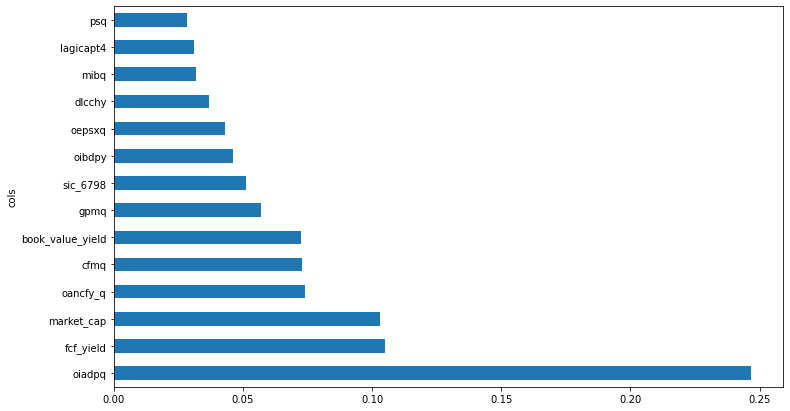

In [391]:
plot_fi(features);

#### We are left with a much smaller set of features

In [392]:
cols = features['cols'].values

In [393]:
len(cols)

14

In [394]:
cols

array(['oiadpq', 'fcf_yield', 'market_cap', 'oancfy_q', 'cfmq',
       'book_value_yield', 'gpmq', 'sic_6798', 'oibdpy', 'oepsxq',
       'dlcchy', 'mibq', 'lagicapt4', 'psq'], dtype=object)

### We cut down the training and validation data sets to only include the relevant features and retrain the tree on the reduced data set

In [395]:
train_red = pd.DataFrame(data = scaler.fit_transform(train[cols].values),columns = cols)
valid_red = pd.DataFrame(data = scaler.transform(valid[cols].values),columns = cols)
test_red = pd.DataFrame(data = scaler.transform(test[cols].values),columns = cols)

In [396]:
t_clf.fit(train_red,y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=300, random_state=123)

In [397]:
t_clf.score(train_red,y_train)

0.5901578801588034

In [398]:
t_clf.score(valid_red,y_valid)

0.5844155844155844

In [437]:
t_clf.feature_names_in_

array(['oiadpq', 'fcf_yield', 'market_cap', 'oancfy_q', 'cfmq',
       'book_value_yield', 'gpmq', 'sic_6798', 'oibdpy', 'oepsxq',
       'dlcchy', 'mibq', 'lagicapt4', 'psq'], dtype=object)

In [399]:
pred_valid = t_clf.predict(valid_red)

In [400]:
Counter(y_valid)

Counter({1: 631, -1: 403, 0: 121})

In [401]:
Counter(pred_valid)

Counter({1: 1055, -1: 100})

In [402]:
confusion_matrix(y_valid,pred_valid)

array([[ 68,   0, 335],
       [  8,   0, 113],
       [ 24,   0, 607]], dtype=int64)

In [403]:
profit = (pred_valid * df_valid['next_period_return'].values).sum()

In [404]:
profit

4.020640000000023

In [405]:
valid_1 = valid_red.copy()

valid_1['rets'] = df_valid['next_period_return'].values

In [406]:
len(valid_1.columns)

15

In [407]:
pred = t_clf.predict(valid_red)

In [408]:
(pred*valid_1[valid_1.columns[-1]].values).sum()

4.020640000000023

In [418]:
# !pip install shap

In [409]:
import shap

In [410]:
def model(features):
    tree_features = features[features.columns[:-1].values]

    pred = t_clf.predict(tree_features)

    ret = pred * features[features.columns[-1]]

    return ret

In [411]:
np.sum(model(valid_1))

4.020640000000023

In [412]:
explainer = shap.explainers.Permutation(model,valid_1)

In [413]:
shap_values = explainer(valid_1,max_evals=2000)

Permutation explainer: 1156it [03:51,  4.73it/s]                                                                       


In [420]:
shap_values.values.shape

(1155, 15)

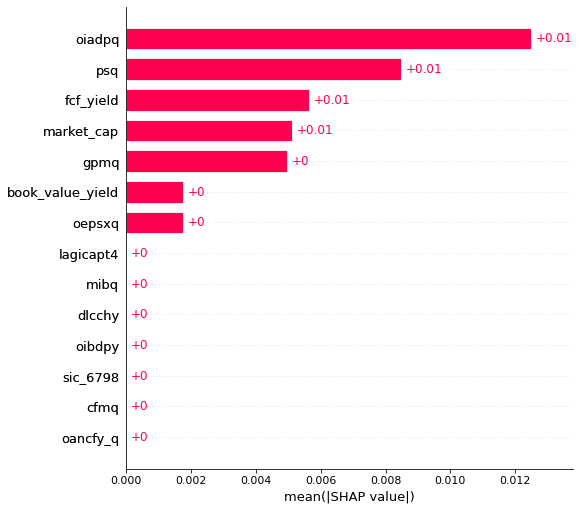

In [414]:
shap.plots.bar(shap_values[:,:-1],max_display=30)

In [421]:

shap_cols = ['oiadpq','psq','fcf_yield','market_cap','gpmq','book_value_yield','oepsxq']


In [422]:
len(shap_cols)

7

In [423]:
len(valid_1.columns[:-1])

14

In [424]:
shap_values[:,:-1].values.shape

(1155, 14)

In [425]:
len(valid_1.columns[:-1])

14

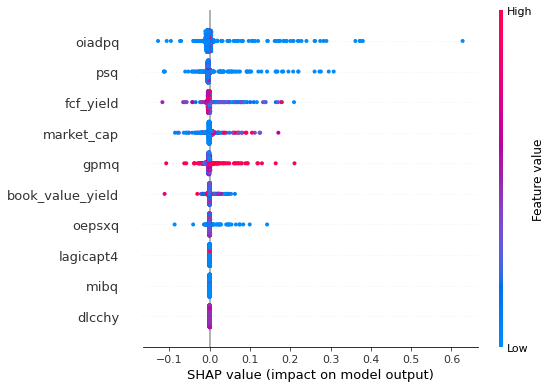

In [426]:
shap.summary_plot(shap_values[:,:-1], features=valid_1[valid_1.columns[:-1]],max_display=10)

In [219]:
valid_1 = valid[cols].copy()
valid_1['rets'] = df_valid['next_period_return'].values

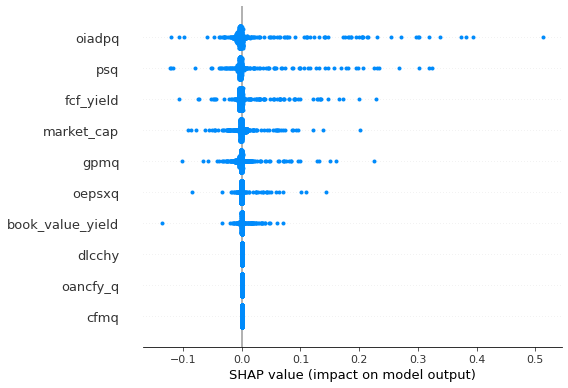

In [356]:
shap.summary_plot(shap_values[:,:-1], features=list(valid_1.columns), class_inds=[2], max_display=10)

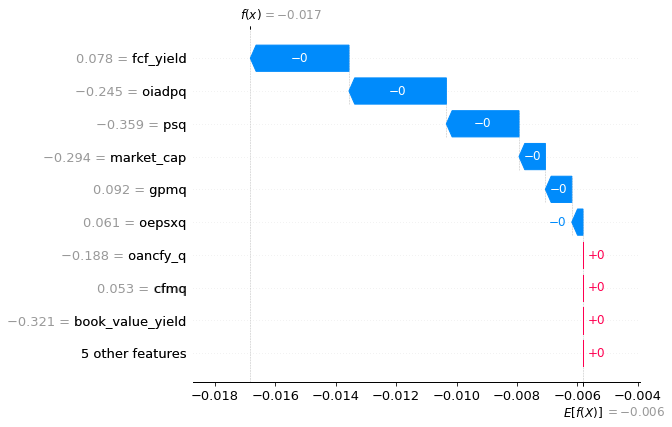

In [427]:
shap.plots.waterfall(shap_values[10,:-1],max_display=10)

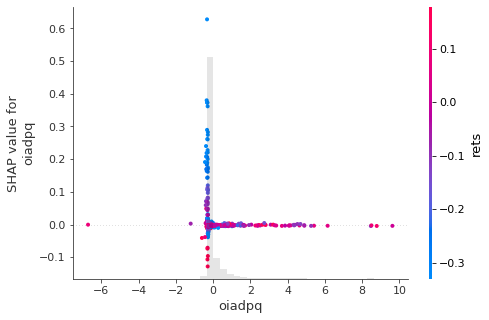

In [428]:
shap.plots.scatter(shap_values[:,'oiadpq'], color=shap_values)

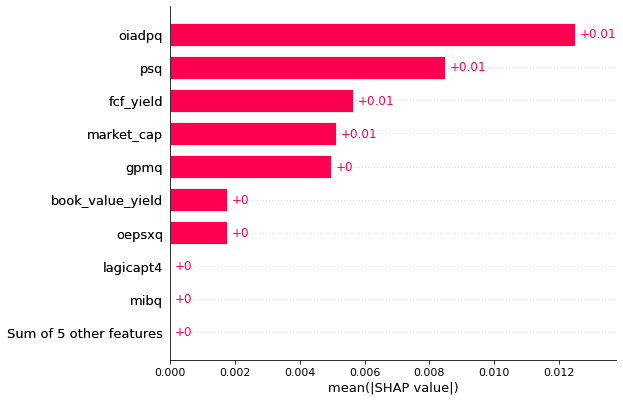

In [429]:
shap.plots.bar(shap_values[:,:-1])

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


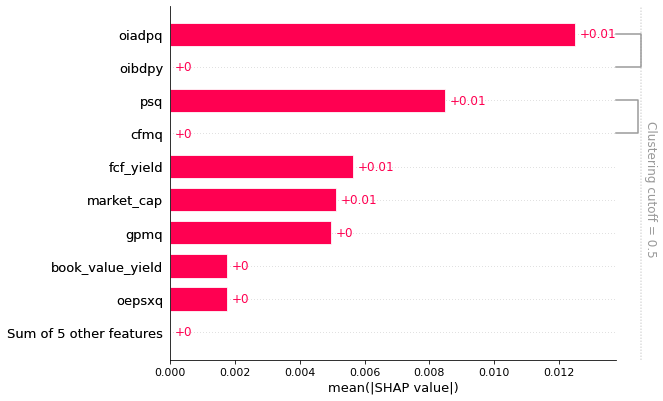

In [430]:
clustering = shap.utils.hclust(valid_1[valid_1.columns[:-1]], y_valid) # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models
shap.plots.bar(shap_values[:,:-1], clustering=clustering)

In [431]:
shap.initjs()
shap.plots.force(shap_values[200,:-1])

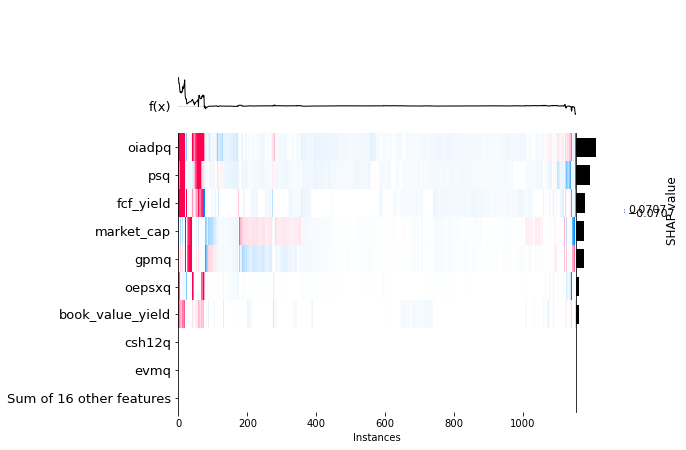

In [267]:
shap.plots.heatmap(shap_values[:,:-1])

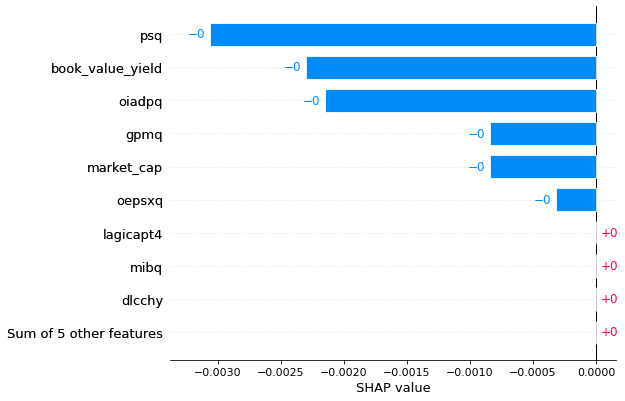

In [432]:
shap.plots.bar(shap_values[200,:-1])

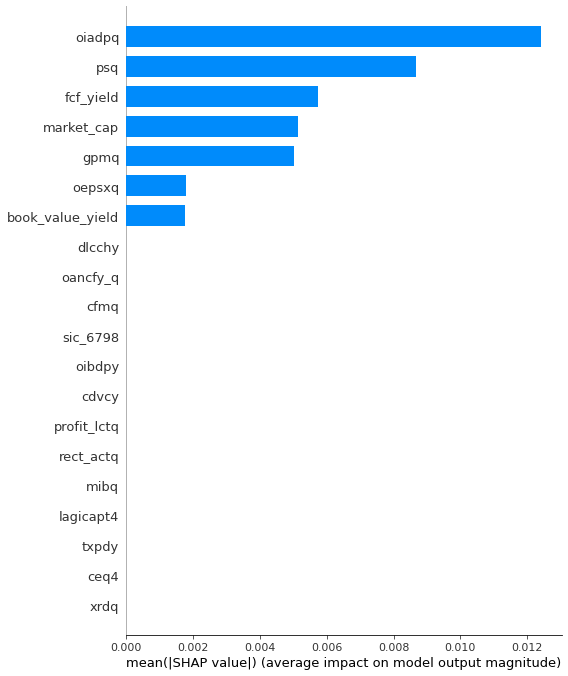

In [226]:
shap.summary_plot(shap_values[:,:-1], valid_1[valid_1.columns[:-1]], plot_type="bar")

## How well does it do on the test set?

In [440]:
test_set = test_red[shap_cols]
pred_test = t_clf1.predict(test_set)
# pred_test_avr = pred_test_avr/np.abs(pred_test_avr).sum()
(pred_test * df_test['next_period_return']).sum()

84.19119100000003

In [434]:
t_clf1 = DecisionTreeClassifier(**study.best_params,random_state=123)

In [435]:
t_clf1.fit(train[shap_cols],y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=300, random_state=123)

In [438]:
dot_data = tree.export_graphviz(t_clf1,out_file=None)
graph = graphviz.Source(dot_data)
graph.render('tree_12')

'tree_12.pdf'

In [449]:
t_clf1.feature_names_in_

array(['oiadpq', 'psq', 'fcf_yield', 'market_cap', 'gpmq',
       'book_value_yield', 'oepsxq'], dtype=object)

In [448]:
valid_red[shap_cols]

,oiadpq,psq,fcf_yield,market_cap,gpmq,book_value_yield,oepsxq
0,-0.234184,-0.283716,0.071916,-0.244409,0.016420,-0.710792,-0.175098
1,-0.032291,-0.144387,-0.010366,0.043084,0.071360,-0.831917,0.069948
2,0.576600,0.982585,0.066378,0.212774,-0.002236,-0.831917,0.901353
3,2.525053,0.982585,0.120505,0.673599,-0.002236,0.042486,1.820274
4,0.094043,0.982585,0.524469,-0.077149,-0.002236,0.042486,0.297490
...,...,...,...,...,...,...,...
1150,0.142529,-0.091323,0.382275,-0.062428,0.124550,-0.259882,0.472523
1151,2.398312,1.707171,-0.053815,0.873129,0.055656,0.024386,0.726320
1152,0.854442,1.707171,-0.237034,-0.230318,0.055656,0.024386,-0.376385
1153,-0.156885,-0.166306,0.064127,-0.243402,0.007001,0.241426,0.113706


In [450]:
valid_set = valid_red[shap_cols]
pred_test = t_clf1.predict(valid_set)
# pred_test_avr = pred_test_avr/np.abs(pred_test_avr).sum()
(pred_test * df_valid['next_period_return']).sum()

4.020640000000023

## If we were 100% correct on the test set we would get this profit

In [451]:
(y_test * df_test['pred_rel_return']).sum()

113.34048000000001

## A totally random strategy where we randomly decide whether to buy or sell

In [442]:
m = len(df_test['next_period_return'])

In [443]:
random_predictions = []
for _ in range(1000):
    pred_random = np.random.choice([-1,0,1],m)
    random_predictions.append((pred_random * df_test['next_period_return']).sum())
    

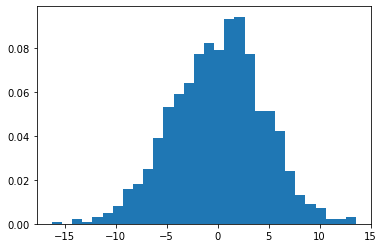

In [444]:
plt.hist(random_predictions,bins=30,density=True);

In [335]:
np.mean(random_predictions)

0.3030609289999995

## Now we run this strategy over the whole period and see how it performs

In [336]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(58)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [337]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [338]:
training_data = [d.reset_index() for d in training_frames]

In [339]:
test_data = [d.reset_index() for d in test_frames]

In [340]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [341]:
scalers = [StandardScaler() for _ in range(len(training_data))]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(training_data))]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(test_data))]

In [342]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        t_clf.fit(opt_training_data[i],training_labels[i])

        preds = t_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

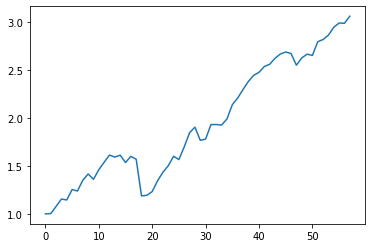

In [452]:
plt.plot(x);

In [236]:
len(x)

58

## Compared to a buy-and-hold of SPY

In [344]:
SPY = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\SPY_cum_ret.pkl')
SPY = SPY.loc['2004-04-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0]+1)
SPY['strategy'] = x

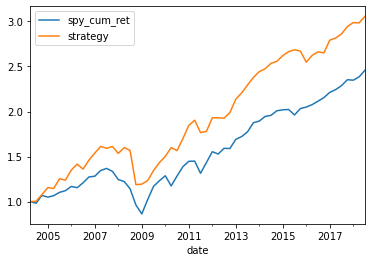

In [345]:
SPY.plot();

In [346]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
print('Strategy Sharpe Ratio: ',strategy_mean_ret/strategy_std)

Strategy Sharpe Ratio:  0.43225473187964636


In [347]:
strategy_std

0.08352985589809588

In [348]:
spy_mean_ret = (SPY['spy_cum_ret'] - 1).diff().mean()
spy_std = (SPY['spy_cum_ret'] - 1).diff().std()
print('SPY Sharpe Ratio: ',spy_mean_ret/spy_std)

SPY Sharpe Ratio:  0.3825904447137517


In [349]:
print(spy_std)

0.06690829328830444


### Total Returns

In [350]:
x[-1]

3.058052001515085

In [351]:
SPY['spy_cum_ret'][-1]

2.459113

### Computing the (quarterly) $\alpha$ of the strategy

In [453]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

In [454]:
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

0.7217252621919491

In [455]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

0.25871496302388025

In [456]:
alpha = np.mean(residual_ret)
alpha

0.017631110333726375